In [29]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from typing import List, Dict, Set

class SyntheticMarketDataGenerator:
    def __init__(self, 
                 num_records: int = 100_000,  # 100K trades
                 start_date: str = "2020-01-01",
                 end_date: str = "2020-03-01",  # 2 months
                 num_investors: int = 500,     # Reduced for more density
                 num_manipulators: int = 20,   # Giant manipulator group of 20
                 symbols: List[str] = None):
        
        self.num_records = num_records
        self.start_date = datetime.strptime(start_date, "%Y-%m-%d")
        self.end_date = datetime.strptime(end_date, "%Y-%m-%d")
        self.num_investors = num_investors
        self.num_manipulators = num_manipulators
        self.symbols = symbols or ["FAKE"]
        
        # Trading hours: 9 AM to 3 PM (6 hours)
        self.market_open = timedelta(hours=9)
        self.market_close = timedelta(hours=15)
        
        # Generate investor IDs
        self.all_investors = [f"INV_{i:04d}" for i in range(1, num_investors + 1)]
        self.manipulators = self.all_investors[:num_manipulators]  # First 20 are manipulators
        self.manipulators = [f"M_{inv}" for inv in self.manipulators]
        self.normal_investors = self.all_investors[num_manipulators:]
        
        # Track used seconds to avoid collisions
        self.used_seconds = set()
        
    def _get_random_market_time(self, day: datetime) -> datetime:
        """Get random time during market hours"""
        random_seconds = random.randint(0, 6 * 3600 - 1)  # 6 hours in seconds
        market_time = day + self.market_open + timedelta(seconds=random_seconds)
        return market_time
    
    def _generate_manipulator_group_trade(self, timestamp: datetime) -> Dict:
        """Generate trade with 2-6 manipulators from the giant group in same second"""
        # Randomly select 2-6 manipulators to trade in this second
        group_size = random.randint(2, 6)
        active_manipulators = random.sample(self.manipulators, group_size)
        
        # Generate 1-3 trades among these manipulators in this second
        trades = []
        num_trades = random.randint(1, 3)
        
        for _ in range(num_trades):
            # 40% chance: trade between manipulators, 60%: with normal investors
            if random.random() < 0.4 and len(active_manipulators) >= 2:
                buyer_id, seller_id = random.sample(active_manipulators, 2)
            else:
                # Trade with normal investor
                if random.random() < 0.5:
                    buyer_id = random.choice(active_manipulators)
                    seller_id = random.choice(self.normal_investors)
                else:
                    seller_id = random.choice(active_manipulators)
                    buyer_id = random.choice(self.normal_investors)
            
            symbol = random.choice(self.symbols)
            price = round(random.uniform(5.0, 7.0), 2)
            quantity = random.choice([100, 200, 500, 1000])
            
            trades.append({
                'buyer_id': buyer_id,
                'seller_id': seller_id,
                'symbol': symbol,
                'price': price,
                'quantity': quantity,
                'date_time': timestamp
            })
        
        return trades
    
    def _generate_normal_trade(self, timestamp: datetime) -> Dict:
        """Generate a normal trade between random investors"""
        buyer_id = random.choice(self.normal_investors)
        seller_id = random.choice(self.normal_investors)
        
        while seller_id == buyer_id:
            seller_id = random.choice(self.normal_investors)
        
        symbol = random.choice(self.symbols)
        price = round(random.uniform(5.0, 15.0), 2)
        quantity = random.randint(1, 500)
        
        return {
            'buyer_id': buyer_id,
            'seller_id': seller_id,
            'symbol': symbol,
            'price': price,
            'quantity': quantity,
            'date_time': timestamp
        }
    
    def generate_data(self) -> pd.DataFrame:
        """Generate the synthetic market data"""
        data = []
        total_days = (self.end_date - self.start_date).days
        
        # First, ensure manipulators co-occur frequently
        print("Generating manipulator co-occurrence trades...")
        
        # Target: Each pair of manipulators should co-occur 100+ times
        # With 20 manipulators, there are 190 possible pairs
        # We'll create concentrated trading activity
        
        co_occurrence_target = 120  # Slightly above 100
        
        # Generate concentrated trading days
        for day_offset in range(total_days):
            current_day = self.start_date + timedelta(days=day_offset)
            
            # Skip weekends (optional)
            if current_day.weekday() >= 5:  # 5=Saturday, 6=Sunday
                continue
                
            # Generate high-frequency trading for manipulators on each trading day
            seconds_in_trading_day = 6 * 3600  # 6 hours
            
            for second_offset in range(0, seconds_in_trading_day, 10):  # Every 10 seconds
                if len(data) >= self.num_manipulators * co_occurrence_target * 3:  # manipulator trades
                    break
                    
                timestamp = current_day + self.market_open + timedelta(seconds=second_offset)
                
                # Generate manipulator group trades
                trades = self._generate_manipulator_group_trade(timestamp)
                data.extend(trades)
        
        # Fill remaining with normal trades
        print("Generating normal trades...")
        remaining_records = self.num_records - len(data)
        
        for _ in range(remaining_records):
            random_day = random.randint(0, total_days - 1)
            current_day = self.start_date + timedelta(days=random_day)
            
            # Only generate during trading hours
            if current_day.weekday() < 5:  # Weekdays only
                timestamp = self._get_random_market_time(current_day)
                trade = self._generate_normal_trade(timestamp)
                data.append(trade)
        
        df = pd.DataFrame(data)
        df = df.sort_values('date_time').reset_index(drop=True)
        
        return df
    
config = {
    "num_records": 100_000,      # 100K trades
    "start_date": "2020-01-01",
    "end_date": "2020-03-01",    # 2 months
    "num_investors": 1000,        # 1000 total investors
    "num_manipulators": 20,      # Giant group of 20 manipulators
    "symbols": ["FAKE"]
}

generator = SyntheticMarketDataGenerator(**config)
df = generator.generate_data()

# Save to CSV
output_file = "synthetic_market_data_100K_2months.csv"
df.to_csv(output_file, index=False)

print(f"\n✅ Data generation complete!")
print(f"📊 Total records: {len(df):,}")
print(f"📅 Date range: {df['date_time'].min()} to {df['date_time'].max()}")
print(f"👥 Unique investors: {len(set(df['buyer_id'].tolist() + df['seller_id'].tolist()))}")
print(f"🎯 Manipulators: {len(generator.manipulators)}")
print(f"💾 Saved to: {output_file}")

Generating manipulator co-occurrence trades...
Generating normal trades...

✅ Data generation complete!
📊 Total records: 73,841
📅 Date range: 2020-01-01 09:00:00 to 2020-02-28 14:59:55
👥 Unique investors: 1000
🎯 Manipulators: 20
💾 Saved to: synthetic_market_data_100K_2months.csv


In [30]:
import pandas as pd

# Load CSV into DataFrame
df = pd.read_csv("synthetic_market_data_100K_2months.csv")

# Show first few rows
print(df.head())

# Show column names
print("\nColumns:", df.columns.tolist())

     buyer_id   seller_id symbol  price  quantity            date_time
0  M_INV_0009    INV_0932   FAKE   6.90       500  2020-01-01 09:00:00
1  M_INV_0014  M_INV_0011   FAKE   6.78       500  2020-01-01 09:00:00
2  M_INV_0020    INV_0871   FAKE   5.67       500  2020-01-01 09:00:00
3    INV_0953    INV_0080   FAKE   8.92       446  2020-01-01 09:00:07
4    INV_0717    INV_0522   FAKE   7.59       455  2020-01-01 09:00:08

Columns: ['buyer_id', 'seller_id', 'symbol', 'price', 'quantity', 'date_time']


In [31]:
import pandas as pd
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Load CSV
df = pd.read_csv("synthetic_market_data_100K_2months.csv")

# Convert to datetime and floor to minute
df["date_time"] = pd.to_datetime(df["date_time"])
df["minute"] = df["date_time"].dt.floor("min")

# ollect all investors (buyers + sellers)
df["buyer"] = df["buyer_id"]
df["seller"] = df["seller_id"]

# Melt into a single column of investors
investors = pd.melt(
    df,
    id_vars=["minute"],
    value_vars=["buyer", "seller"],
    value_name="investor_id"
)[["minute", "investor_id"]]

# Drop duplicates: each investor appears once per minute
investors = investors.drop_duplicates()

# Build basket (one-hot encoding: minute × investor)
baskets = (
    investors.assign(flag=1)
             .pivot_table(index="minute", columns="investor_id", values="flag", fill_value=0)
)

min_support = 150 / len(baskets)
frequent_itemsets = fpgrowth(baskets, min_support=min_support, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.25)
print(rules[['antecedents','consequents','support','confidence','lift']])


/home/erhan/Desktop/Erhan/python-projects/finance/finance_venv/lib64/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


     antecedents   consequents   support  confidence       lift
0   (M_INV_0005)  (M_INV_0009)  0.010745    0.534202  26.472482
1   (M_INV_0009)  (M_INV_0005)  0.010745    0.532468  26.472482
2   (M_INV_0014)  (M_INV_0009)  0.010352    0.519737  25.755660
3   (M_INV_0009)  (M_INV_0014)  0.010352    0.512987  25.755660
4   (M_INV_0014)  (M_INV_0013)  0.011073    0.555921  27.819748
..           ...           ...       ...         ...        ...
57  (M_INV_0013)  (M_INV_0003)  0.009893    0.495082  25.615038
58  (M_INV_0014)  (M_INV_0003)  0.010352    0.519737  26.890656
59  (M_INV_0003)  (M_INV_0014)  0.010352    0.535593  26.890656
60  (M_INV_0001)  (M_INV_0005)  0.010417    0.565836  28.131464
61  (M_INV_0005)  (M_INV_0001)  0.010417    0.517915  28.131464

[62 rows x 5 columns]


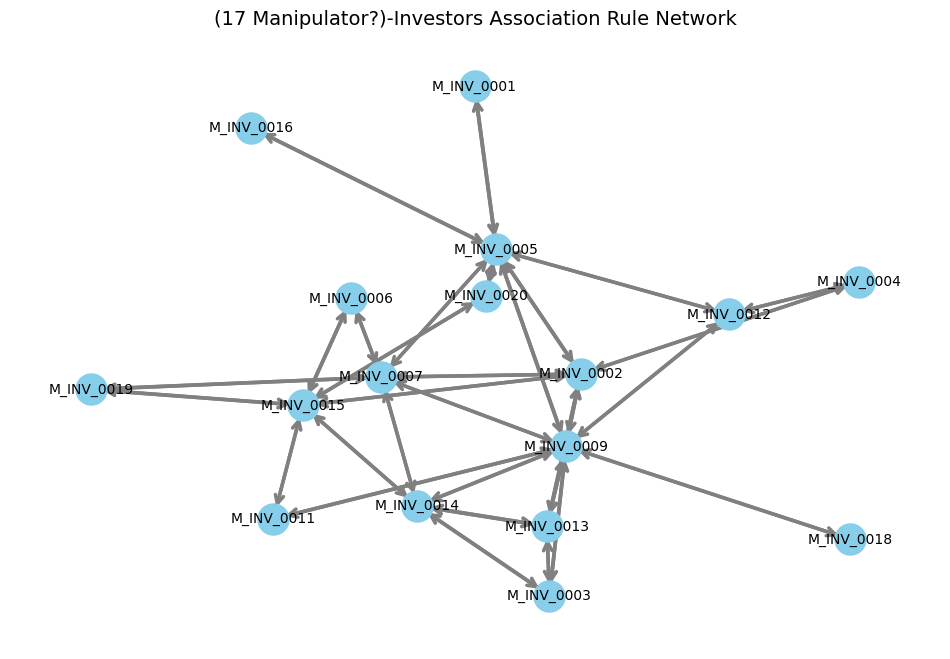

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

# Suppose you already have your rules DataFrame
# from association_rules(...)
# rules[['antecedents','consequents','support','confidence','lift']]

# Create directed graph
G = nx.DiGraph()

# Add edges from rules
for _, row in rules.iterrows():
    # antecedents and consequents are frozensets -> convert to list
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(
                a, c,
                weight=row['confidence'],   # edge weight
                lift=row['lift']
            )

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.3, seed=42)  # force-directed layout

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue")

# Draw edges (thicker if higher confidence)
edges = nx.draw_networkx_edges(
    G, pos,
    arrowstyle="->", arrowsize=15,
    edge_color="gray",
    width=[d['weight']*5 for (_,_,d) in G.edges(data=True)]
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title(f"({G.number_of_nodes()} Manipulator?)-Investors Association Rule Network", fontsize=14)
plt.axis("off")
plt.savefig("investor_network.png", format="png", dpi=300, bbox_inches="tight")
plt.show()


In [33]:
import networkx as nx
from pyvis.network import Network
from IPython.display import display, HTML

# Create directed graph from rules
G = nx.DiGraph()

for _, row in rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(
                a, c,
                weight=row['confidence'],
                title=f"support={row['support']:.3f}, conf={row['confidence']:.2f}, lift={row['lift']:.2f}"
            )

# Create PyVis network for notebook
net = Network(notebook=True, directed=True, height="750px", width="100%")

# Load the NetworkX graph
net.from_nx(G)

# Enable physics for nicer layout
net.toggle_physics(True)

# Display directly in Jupyter notebook
net.show("investor_rules_network_notebook.html")  # renders inline

import webbrowser
webbrowser.open("./investor_rules_network_notebook.html")


investor_rules_network_notebook.html


True